In [3]:
import argparse
import json
import os
import random
import sys

import numpy as np
import torch
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score as R2
from torch_geometric.nn import Linear, SAGEConv, global_mean_pool
import time
# from utils import *


def seed_all(seed):
    '''
    Set random seeds for reproducability
    '''
    if not seed:
        seed = 42
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


class GNN(torch.nn.Module):
    '''
    Graph Neural Network
    '''
    def __init__(self, N_fl1, N_mpl, N_fl2, N_fl3):
        super(GNN, self).__init__()
        self.pre = Linear(5, N_fl1)
        self.conv1 = SAGEConv(N_fl1, N_mpl, normalize=True)
        self.conv2 = SAGEConv(N_mpl, N_mpl, normalize=True)
        self.post1 = Linear(N_mpl, N_fl2)
        self.post2 = Linear(N_fl2, N_fl3)
        self.out = Linear(N_fl3, 1)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        
        # Pre Processing Linear Layer
        x = F.relu(self.pre(x))
        # 1. Obtain node embeddings
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        
        # 2. Readout layer
        x = global_mean_pool(x, batch)
        # 3. Apply Fully Connected Layers
        x = F.relu(self.post1(x))
        x = F.relu(self.post2(x))
        # print(x.size())
        x = self.out(x)
        return x


def init_model():
    '''
    Initialize model
    '''
    seed_all(seed)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = GNN(N_fl1, N_mpl, N_fl2, N_fl3).to(device)
    optimizer = torch.optim.Adam(
        model.parameters(), lr=l_rate, weight_decay=w_decay)
    return model, optimizer


def train(model, optimizer, train_loader, val_loader, n_epoch, prop, config, fold):
    '''
    Train GNN
    '''
    filename = f'{output_dir}/eval-{eval}_config-{config}_fold-{fold}_loss_history.txt'
    output = open(filename, "w")

    print('Epoch Training_MSE Validation_MSE', file=output, flush=True)

    seed_all(seed)
    for epoch in range(n_epoch):
        model.train()
        # Train batches
        for train_batch in train_loader:
            train_batch = train_batch.to(device)
            train_pred = model(train_batch)
            train_true = getattr(train_batch, prop)
            train_loss = F.mse_loss(train_pred, train_true)
            train_loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Evaluate
        val_pred, val_true = test(model, val_loader, prop)
        val_loss = F.mse_loss(val_pred, val_true)
        print(f'{epoch:d}, {train_loss:e}, {val_loss:e}', file=output, flush=True)
    return


def test(model, data_loader, prop):
    '''
    Test GNN
    '''
    seed_all(seed)
    model.eval()
    data = next(iter(data_loader)).to(device)
    pred = model(data)
    true = getattr(data, prop)
    return pred, true


if __name__ == '__main__':
    
    eval = 2
    prop = 'strength'
    config_dir = './'
    config = 0
    output_dir = './out/'
    seed = 42

    if not os.path.exists(config_dir):
        os.makedirs(config_dir)

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    config_name = config_dir + str(config) + '.json'
    with open(config_name, 'r') as h:
        params = json.load(h)

    l_rate = params['l_rate']
    w_decay = params['w_decay']
    n_epoch = params['n_epoch']
    b_size = params['b_size']
    N_fl1 = params['N_fl1']
    N_mpl = params['N_mpl']
    N_fl2 = params['N_fl2']
    N_fl3 = params['N_fl3']

    # Set seeds for complete reproducability
    seed_all(seed)

    # Define the model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    cases = ['Train (A-G) / Test (A-G)',
             'Train (A-G) / Test (H-L)']

    print('\n====== Configuration ======')
    print(f'Evaluation #{eval}:\t\t{cases[eval-2]}')
    print(f'Regression task:\t{prop}')
    print(f'Hyper-parameters :\t{config}.json')

# *************************************************************************** #
    print('\n====== Training / Testing ======')
    start = time.time()
    # Eval == 2 or 3 : Train/Test (A-G) or Train/Test (A-G)/(H-L)

    # Load data
    def seed_worker(worker_id):
        '''Seeding for DataLoaders'''
        worker_seed = torch.initial_seed() % 2**32
        np.random.seed(42)
        random.seed(42)

    # Load data
    train_loader = torch.load("data/train_dataset.pt",weights_only=False)

    #### Eval = 2 if you're running Evaluation-1 and Eval = 3 if you're running Evaluation-2
    if eval==2:
        test_loader = torch.load("data/test_dataset_2.pt",weights_only=False)
    else:
        test_loader = torch.load("data/test_dataset_3.pt",weights_only=False)

    # Define model and optimizer
    model, optimizer = init_model()

    #### Load the checkpoint file if you directly want results else train
#   model.load_state_dict(torch.load("out/ALL_LIF_eval-2_config-0_prop-strength_fold-NA_checkpoint_AFTER_REVISION_NO_NORM.pth",map_location=torch.device('cpu')))
    model.eval()

    # Train model
    train(model, optimizer, train_loader, test_loader,
          n_epoch, prop, config, 'NA')

    # Test Model
    preds, trues = test(model, test_loader, prop)

    # Save model
    torch.save(
        model.state_dict(), f"{output_dir}/REVISION_eval-{eval}_config-{config}_prop-{prop}_fold-{'NA'}_checkpoint.pth")

    print(f'Processing time: {time.time()-start:.2f} seconds')
# *************************************************************************** #
    # Report and Visualize predictions

    print('\n====== RESULTS ======')
    preds = scaler[prop].inverse_transform(
        preds.detach().detach().cpu().numpy())
    trues = scaler[prop].inverse_transform(
        trues.detach().detach().cpu().numpy())
    meanARE, maxARE = mean_maxARE(preds, trues)

    print(f'(MeanARE, MaxARE):\t({meanARE}, {maxARE})')
    # plot_results(preds, trues, output_dir, eval, config, prop)


FileNotFoundError: [Errno 2] No such file or directory: './0.json'

Plot Results

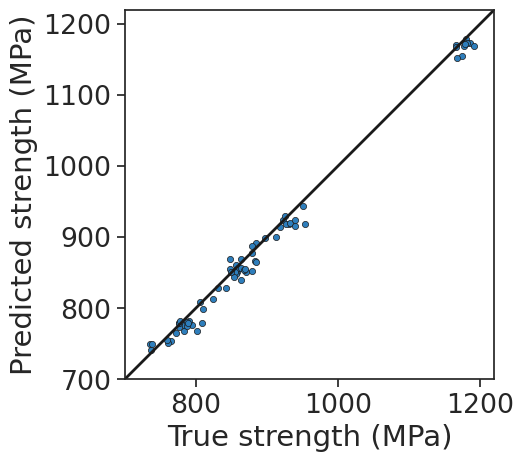

In [3]:

def plot_results(preds, trues, output_dir, eval, config, prop):

    if prop == 'strength':
        preds = preds*1000
        trues = trues*1000

    '''Plot evaluation results
    '''
    sns.set(font_scale=1.75)
    sns.set_style("ticks")
    # fig, ax = plt.subplots(figsize=(8.5, 5.5), dpi=300)
    fig, ax = plt.subplots()

    minColor = 0.4
    maxColor = 1.00
    if prop == 'stiffness':
        cmap = truncate_colormap(plt.get_cmap("Greens"), minColor, maxColor)
    else:
        cmap = truncate_colormap(plt.get_cmap("Blues"), minColor, maxColor)
    col = mcolors.to_hex(cmap(0.5))

    if eval != 2:
        x = np.squeeze(trues)
        y = np.squeeze(preds)
        xy = np.vstack([x, y])
        z = gaussian_kde(xy)(xy)
        # Sort the points by density, so that the densest points are plotted last
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

        plt.scatter(x,
                    y,
                    c=z,
                    s=20,
                    cmap=cmap)
    else:
        plt.scatter(trues,
                    preds,
                    s=20,
                    ec='k',
                    lw=0.5,
                    color=col)
    if prop == 'strength':
        plt.xlabel('True strength (MPa)')
        plt.ylabel('Predicted strength (MPa)')
        plt.xlim([700, 1220])
        plt.ylim([700, 1220])
        plt.plot([700, 1220], [700, 1220], '-k', linewidth=2)
    else:
        plt.xlabel('True modulus (GPa)')
        plt.ylabel('Predicted modulus (GPa)')
        plt.xlim([110, 152])
        plt.ylim([110, 152])
        plt.plot([110, 152], [110, 152], '-k', linewidth=2)

    ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')

    plt.savefig(f'/mnt/sdb1/graphspiking/graph_spiking/PolyGRAPH-main/REVISION_RESULTS/ANN_eval-{eval}_prop-{prop}_config-{config}.parity.png', dpi=300, bbox_inches="tight")

plot_results(preds/1000, trues/1000, output_dir, eval, config, prop)

MSE Values

In [4]:
pred_norm = scaler[prop].transform(
        preds)
true_norm = scaler[prop].transform(
        trues)

# REMEMBER NORMALIZED IS ALREADY MULTIPLIED BY 1000
np.mean((preds-trues)**2), np.mean((pred_norm-true_norm)**2)*1000, pred_norm.shape, true_norm.shape

(172.53734, 10.375489480793476, (70, 1), (70, 1))